In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd

def extractType(fl): return fl.split('/')[-1].split('_')[-2]
def extractRegion(fl): return fl.split('/')[-1].split('_')[-3].split('r')[-1]
def extractComparison(fl): return fl.split('/')[-1].split('_')[-1].split('.')[-2]
def makeGeomPath(reg): return './data/nhrus/clean_AEA/nhru_%s_clean.shp'%(reg)

In [2]:
files = pd.DataFrame()
files['dataPath'] = glob.glob('./data/forcing_sets/*.pcl')
files['region'] = files.dataPath.map(extractRegion)
files['forcingType'] = files.dataPath.map(extractType)
files['forcingComp'] = files.dataPath.map(extractComparison)
files['geomPath'] = files.region.map(makeGeomPath)

In [3]:
tmp = pd.read_pickle(files.dataPath[0])

In [4]:
tmp.head()

,HRU,r2,MAE,RMSE,NSE,R,pVal
0,1,0.909640,3.321430,4.460846,-3.602720e+19,0.964840,0.0
1,2,0.909346,3.366396,4.459051,-5.286450e+19,0.965470,0.0
2,3,0.905771,3.404581,4.579873,-4.583243e+19,0.963649,0.0
3,4,0.905814,3.402250,4.577619,2.006800e+19,0.963649,0.0
4,5,0.879429,3.959195,5.162532,5.223228e+19,0.947673,0.0


In [5]:
files.head()

,dataPath,region,forcingType,forcingComp,geomPath
0,./data/forcing_sets/r11_tmax_livneh2idaho.pcl,11,tmax,livneh2idaho,./data/nhrus/clean_AEA/nhru_11_clean.shp
1,./data/forcing_sets/r15_tmin_daymet2idaho.pcl,15,tmin,daymet2idaho,./data/nhrus/clean_AEA/nhru_15_clean.shp
2,./data/forcing_sets/r13_tmax_daymet2idaho.pcl,13,tmax,daymet2idaho,./data/nhrus/clean_AEA/nhru_13_clean.shp
3,./data/forcing_sets/r15_tmax_maurer2daymet.pcl,15,tmax,maurer2daymet,./data/nhrus/clean_AEA/nhru_15_clean.shp
4,./data/forcing_sets/r05_tmin_livneh2maurer.pcl,05,tmin,livneh2maurer,./data/nhrus/clean_AEA/nhru_05_clean.shp


In [22]:
def computeStats(df):
    geom = gpd.read_file(df.geomPath)
    data = pd.read_pickle(df.dataPath)

    data['area'] = geom.geometry.area # extract area in square m
    data['fracArea'] = data.area/data.area.sum()
    
    # deal with inf values:
    for var in ['RMSE','MAE','R','pVal']:
        data.loc[np.isinf(data[var]),var] = np.NaN
    
    # compute area weighted error metrics
    awRMSE = np.nansum(data['RMSE'].values * data.fracArea.values)
    awMAE = np.nansum(data['MAE'].values * data.fracArea.values)
    awR = np.nansum(data['R'].values * data.fracArea.values)
    awpVal = np.nansum(data['pVal'].values * data.fracArea.values)
    
    # compute traditional mean error metrics
    RMSE = data.RMSE.mean()
    MAE = data.MAE.mean()
    R = data.R.mean()
    pVal = data.pVal.mean()
    
    # count signficant differences
    
    data['pValThresh'] = 0
    data.loc[data.pVal <= 0.05,'pValThresh'] = 1
    
    sigDiff = data.pValThresh.sum()
    n = len(data)
    
    return awRMSE,awMAE,awR,awpVal,RMSE,MAE,R,pVal,sigDiff,n

In [23]:
res = files.apply(computeStats,axis=1)

In [24]:
len(res)

228

In [25]:
awRMSE,awMAE,awR,awpVal,RMSE,MAE,R,pVal,sigDiff,n = zip(*res)
files['awRMSE'] = awRMSE
files['awMAE'] = awMAE
files['awR'] = awR
files['awpVal'] = awpVal
files['RMSE'] = RMSE
files['MAE'] = MAE
files['R'] = R
files['pVal'] = pVal
files['sigDiff'] = sigDiff
files['n'] = n

In [28]:
files['proDiff'] = files.sigDiff/files.n

In [29]:
files.head()

,dataPath,region,forcingType,forcingComp,geomPath,awRMSE,awMAE,awR,awpVal,RMSE,MAE,R,pVal,sigDiff,n,proDiff
0,./data/forcing_sets/r11_tmax_livneh2idaho.pcl,11,tmax,livneh2idaho,./data/nhrus/clean_AEA/nhru_11_clean.shp,5.901911,4.433235,0.954024,0.000155,5.898129,4.426370,0.953924,0.000326,7368,7373,0.999322
1,./data/forcing_sets/r15_tmin_daymet2idaho.pcl,15,tmin,daymet2idaho,./data/nhrus/clean_AEA/nhru_15_clean.shp,4.552335,3.743419,0.967639,0.002424,4.741954,3.905838,0.965445,0.004782,3401,3441,0.988375
2,./data/forcing_sets/r13_tmax_daymet2idaho.pcl,13,tmax,daymet2idaho,./data/nhrus/clean_AEA/nhru_13_clean.shp,5.806188,4.821531,0.957148,0.000023,4.230760,3.271828,0.968551,0.000337,1955,1958,0.998468
3,./data/forcing_sets/r15_tmax_maurer2daymet.pcl,15,tmax,maurer2daymet,./data/nhrus/clean_AEA/nhru_15_clean.shp,1.903952,1.451687,0.993700,0.009541,2.355529,1.866788,0.991984,0.009080,3364,3441,0.977623
4,./data/forcing_sets/r05_tmin_livneh2maurer.pcl,05,tmin,livneh2maurer,./data/nhrus/clean_AEA/nhru_05_clean.shp,0.858971,0.487968,0.998471,0.018028,0.934051,0.548664,0.998221,0.016459,6902,7182,0.961014


In [30]:
files.tail()

,dataPath,region,forcingType,forcingComp,geomPath,awRMSE,awMAE,awR,awpVal,RMSE,MAE,R,pVal,sigDiff,n,proDiff
223,./data/forcing_sets/r16_tmin_maurer2idaho.pcl,16,tmin,maurer2idaho,./data/nhrus/clean_AEA/nhru_16_clean.shp,6.407208,5.338227,0.953798,0.000291,7.019491,5.849473,0.940398,0.002266,2651,2664,0.995120
224,./data/forcing_sets/r12_tmin_maurer2daymet.pcl,12,tmin,maurer2daymet,./data/nhrus/clean_AEA/nhru_12_clean.shp,1.572978,1.120132,0.994754,0.015791,1.716084,1.224399,0.993914,0.017004,7476,7815,0.956622
225,./data/forcing_sets/r01_tmax_maurer2daymet.pcl,01,tmax,maurer2daymet,./data/nhrus/clean_AEA/nhru_01_clean.shp,2.539755,1.878366,0.988710,0.034841,2.248083,1.656445,0.993250,0.033076,2254,2462,0.915516
226,./data/forcing_sets/r02_tmax_livneh2daymet.pcl,02,tmax,livneh2daymet,./data/nhrus/clean_AEA/nhru_02_clean.shp,1.970605,1.403343,0.967489,0.028402,2.117152,1.512157,0.993334,0.027594,4445,4827,0.920862
227,./data/forcing_sets/r10U_tmax_daymet2idaho.pcl,10U,tmax,daymet2idaho,./data/nhrus/clean_AEA/nhru_10U_clean.shp,4.872858,3.803517,0.979804,0.000104,4.916195,3.829624,0.978533,0.000365,10290,10299,0.999126


In [31]:
files.to_pickle('./data/temperature_comparison_area_weighted.pcl')

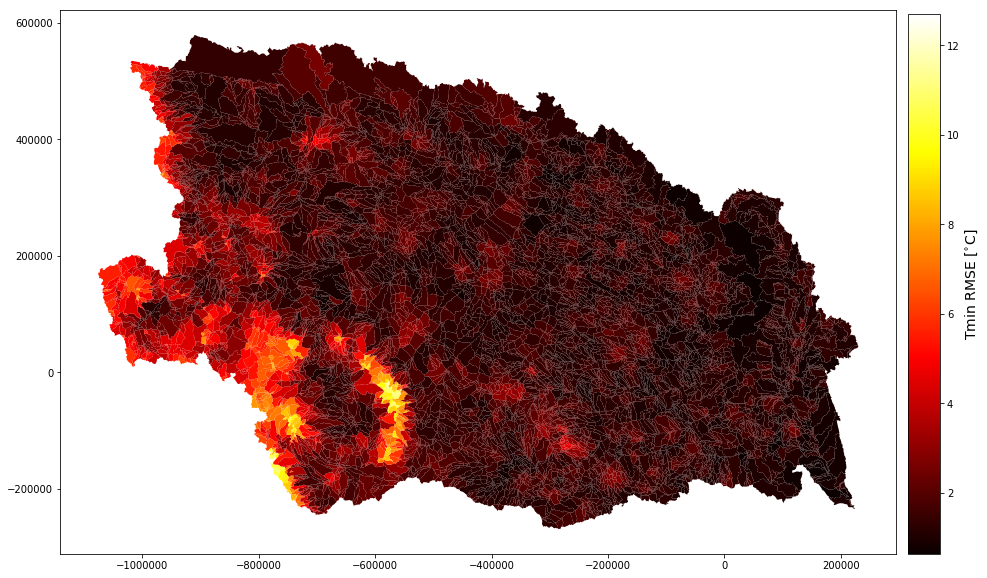

In [101]:
vmin = shp.metric.min()
vmax = shp.metric.max()

ax = shp.plot(column = 'metric', figsize=(15,10), vmin=vmin,vmax=vmax, cmap='hot')

fig = ax.get_figure()
cax = fig.add_axes([0.91, 0.125, 0.03, 0.75])
sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig.colorbar(sm,cax=cax)
# colorbar with geopandas comes from here: https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
cb.set_label(label = 'Tmin RMSE [$^{\circ}$C]', fontsize = 14)